In [1]:
# imports
import os
os.sys.path.append(os.path.abspath(".."))

import tensorflow as tf

import numpy as np
import pandas as pd

import h5py

import project.download_content as content
from project.utils import data
from project.utils.data_bbox_match_hdf5 import standard_bboxes

from tqdm import tqdm

import pickle

from keras.preprocessing import image

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

modelpath = os.path.join(content.DATAPATH, "MODEL")

tqdm.pandas()

Using TensorFlow backend.


This notebook is about create the environment to start to train models.

# Loading data

I created a script called `data_bbox_match_hdf5` to massive preprocess all bounding boxes and create many files called data_preprocessed_<number>. I union all those files in one, called data_preprocessed. This hdf5 contains all bounding boxes preprocessed with some custom shapes and custopm ratios defined in script. Now I am going to loading this joint data.

In [2]:
filepath = os.path.join(modelpath, "data_preprocessed.h5")
all_train = pd.read_hdf(filepath, 'X', mode='r')
all_train.head(2)

,ImageID,LabelName,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Path,LabelSemantic,cx,cy,w,h,accordion,adhesive_tape,aircraft,airplane,alarm_clock,alpaca,ambulance,animal,ant,antelope,apple,armadillo,artichoke,auto_part,axe,backpack,bagel,baked_goods,balance_beam,ball,balloon,banana,band-aid,banjo,barge,barrel,baseball_bat,baseball_glove,bat_(animal),bathroom_accessory,bathroom_cabinet,bathtub,beaker,bear,bed,bee,beehive,beer,beetle,bell_pepper,belt,bench,bicycle,bicycle_helmet,bicycle_wheel,bidet,billboard,billiard_table,binoculars,bird,blender,blue_jay,boat,bomb,book,bookcase,boot,bottle,bottle_opener,bow_and_arrow,bowl,bowling_equipment,box,boy,brassiere,bread,briefcase,broccoli,bronze_sculpture,brown_bear,building,bull,burrito,bus,bust,butterfly,cabbage,cabinetry,cake,cake_stand,calculator,camel,camera,can_opener,canary,candle,candy,cannon,canoe,cantaloupe,car,carnivore,carrot,cart,cassette_deck,castle,cat,cat_furniture,caterpillar,cattle,ceiling_fan,cello,centipede,chainsaw,chair,cheese,cheetah,chest_of_drawers,chicken,chime,chisel,chopsticks,christmas_tree,clock,closet,clothing,coat,cocktail,cocktail_shaker,coconut,coffee,coffee_cup,coffee_table,coffeemaker,coin,common_fig,common_sunflower,computer_keyboard,computer_monitor,computer_mouse,convenience_store,cookie,cooking_spray,corded_phone,cosmetics,couch,countertop,cowboy_hat,crab,cream,cricket_ball,crocodile,croissant,crown,crutch,cucumber,cupboard,curtain,cutting_board,dagger,dairy_product,deer,desk,dessert,diaper,dice,digital_clock,dinosaur,dishwasher,dog,dog_bed,doll,dolphin,door,door_handle,doughnut,dragonfly,drawer,dress,drill_(tool),drink,drinking_straw,drum,duck,dumbbell,eagle,earrings,egg_(food),elephant,envelope,eraser,face_powder,facial_tissue_holder,falcon,fashion_accessory,fast_food,fax,fedora,filing_cabinet,fire_hydrant,fireplace,fish,flag,flashlight,flower,flowerpot,flute,flying_disc,food,food_processor,football,football_helmet,footwear,fork,fountain,fox,french_fries,french_horn,frog,fruit,frying_pan,furniture,garden_asparagus,gas_stove,giraffe,girl,glasses,glove,goat,goggles,goldfish,golf_ball,golf_cart,gondola,goose,grape,grapefruit,grinder,guacamole,guitar,hair_dryer,hair_spray,hamburger,hammer,hamster,hand_dryer,handbag,...,nightstand,oboe,office_building,office_supplies,orange,organ_(musical_instrument),ostrich,otter,oven,owl,oyster,paddle,palm_tree,pancake,panda,paper_cutter,paper_towel,parachute,parking_meter,parrot,pasta,pastry,peach,pear,pen,pencil_case,pencil_sharpener,penguin,perfume,person,personal_care,personal_flotation_device,piano,picnic_basket,picture_frame,pig,pillow,pineapple,pitcher_(container),pizza,pizza_cutter,plant,plastic_bag,plate,platter,plumbing_fixture,polar_bear,pomegranate,popcorn,porch,porcupine,poster,potato,power_plugs_and_sockets,pressure_cooker,pretzel,printer,pumpkin,punching_bag,rabbit,raccoon,racket,radish,ratchet_(device),raven,rays_and_skates,red_panda,refrigerator,remote_control,reptile,rhinoceros,rifle,ring_binder,rocket,roller_skates,rose,rugby_ball,ruler,salad,salt_and_pepper_shakers,sandal,sandwich,saucer,saxophone,scale,scarf,scissors,scoreboard,scorpion,screwdriver,sculpture,sea_lion,sea_turtle,seafood,seahorse,seat_belt,segway,serving_tray,sewing_machine,shark,sheep,shelf,shellfish,shirt,shorts,shotgun,shower,shrimp,sink,skateboard,ski,skirt,skull,skunk,skyscraper,slow_cooker,snack,snail,snake,snowboard,snowman,snowmobile,snowplow,soap_dispenser,sock,sofa_bed,sombrero,sparrow,spatula,spice_rack,spider,spoon,sports_equipment,sports_uniform,squash_(plant),squid,squirrel,stairs,stapler,starfish,stationary_bicycle,stethoscope,stool,stop_sign,strawberry,street_light,stretcher,studio_couch,submarine,submarine_sandwich,suit,suitcase,sun_hat,sunglasses,surfboard,sushi,swan,swim_cap,swimming_pool,swimwear,sword,syringe,table,table_tennis_racket,tablet_computer,tableware,taco,tank,tap,tart,taxi,tea,teapot,teddy_bear,telephone,television,tennis_ball,tennis_racket,tent,tiara,tick,tie,tiger,tin_can,tire,toaster

In [3]:
#adding a column with amount of bbox matched
all_train['bbox_count'] = all_train.bbox_ref.apply(lambda x: len(x))

In [4]:
# get only 3 classes (the 30th, 29th and 28th more relevants - see EDA.html)
all_train = all_train[(all_train.LabelSemantic == 'boat')
                      | (all_train.LabelSemantic == 'land_vehicle')
                      | (all_train.LabelSemantic == 'skyscraper')]

all_train = all_train[all_train.bbox_count > 0]

Now I am going to create the hdf5 target dataset. Which contains all bounding boxes for each image previously matched

In [5]:
datapath = os.path.join(modelpath, "part_data_300_vgg.h5")

In [6]:
# getting all image names
imgs = all_train[['ImageID', 'Path']].drop_duplicates().values

# encoding each one with ascii 
ascii_imgs = np.array([[j.encode("ascii", "ignore") for j in i] for i in imgs])

# saving in dataset called 'images'
with h5py.File(datapath, 'w') as f:
    f.create_dataset('images', ascii_imgs.shape, 
                     data=ascii_imgs,
                     dtype=h5py.special_dtype(vlen=str))
    
# reading example
with h5py.File(datapath, 'r') as f:
    img = f['images'][0]
    print(f"The name of the first data: {img}")

The name of the first data: ['0000339d0372e7e6' 'data/TRAIN/train_0/0000339d0372e7e6.jpg']


In [7]:
# sorting all train df
all_train = all_train.sort_values('ImageID')

In [8]:
f = h5py.File(datapath, 'w')

dt = h5py.vlen_dtype(np.dtype('int16'))

group_size = 10000

try:
    # get the first image
    img = all_train.iloc[0]
    
    # setting initial states ti iterate over all dataframe
    img_name = img[0]
    img_path = img[7]
    images = []
    target = [[img[13:-2].tolist() + img[9:13].tolist()],
              [list(img[-2])]]

    # iterate over all data set
    for i, img in tqdm(enumerate(all_train.iloc[:, :].itertuples())):
        # in first iteration of each batch size create the group
        if i % group_size == 0:
            group = str(int(i/group_size))
            f.create_group(group)

        # save last image when the new one is new
        if img_name != img[1]:
            images.append([img_name.encode("ascii", "ignore"),
                           img_path.encode("ascii", "ignore")])
            
            # create a dataset with the position and classification
            f[group].create_dataset(name=img_name,
                                    data=target[0],
                                    dtype=np.float32,
                                    compression='gzip',
                                    compression_opts=9)

            # create a dataset with the anchors
            dset = f[group].create_dataset(name=f"{img_name}-anchors",
                                           shape=(len(target[1]),),
                                           dtype=dt,
                                           compression='gzip',
                                           compression_opts=9)
    
            for j, row in enumerate(target[1]):
                dset[j] = row
    
            # clean all states
            target = [[], []]
            img_name = img[1]
            img_path = img[8]

        # save the images dataset in last iteration of each batch
        if (i+1) % group_size == 0:
            f[group].create_dataset(name='images',
                                    shape=(len(images), 2), 
                                    data=images,
                                    dtype=h5py.special_dtype(vlen=str))
            images=[]

        target[0].append(list(img[14:-2] + img[10:14]))
        target[1].append(list(img[-2]))   

        
finally:  
    f.close()

36480it [00:21, 1677.89it/s]


#### Reading

image info:  ['011a2199fb81ed9c' 'data/TRAIN/train_0/011a2199fb81ed9c.jpg']
target:  [[0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0. 

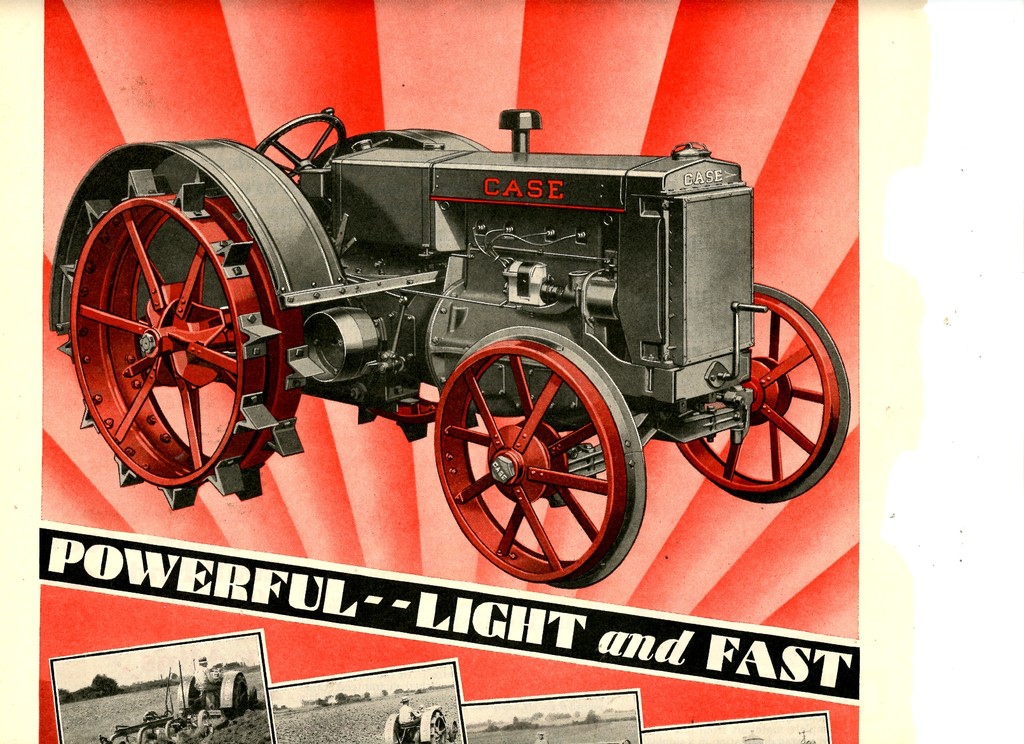

In [9]:
with h5py.File(datapath, 'r') as f:
    image_info = f['0']['images'][:][422]
    print('image info: ', image_info)
    print('target: ', f['0'][image_info[0]][:])
    print('target: ', f['0'][f"{image_info[0]}-anchors"][:])
    display(image.load_img(image_info[1]))